<a href="https://colab.research.google.com/github/oimartin/company_bankruptcy_predictions/blob/main/Notebook_bankrupt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [1]:
# For Colab
# !pip install --upgrade matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 


# Model Fit Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

data = pd.read_csv('https://raw.githubusercontent.com/oimartin/company_bankruptcy_predictions/main/data/data.csv')
data.shape

(6819, 96)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

The company bankrupt data has 6,819 rows with three int64 rows and 92 float64 rows.

# EDA

## Missing Values and Duplicate Values

In [3]:
# double check for missing values
nulls = data.isnull().sum()
nulls[nulls >=1]

Series([], dtype: int64)

There are a total of 6819 rows and no missing values for the 95 input features. The bankruptcy column or output feature also has no missing values 

## Bankrupt?


In [4]:
# Column names originally have extra whitespace
data.columns = data.columns.str.replace(' ', '')

In [5]:
# Observe Bankrupt? values
data['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

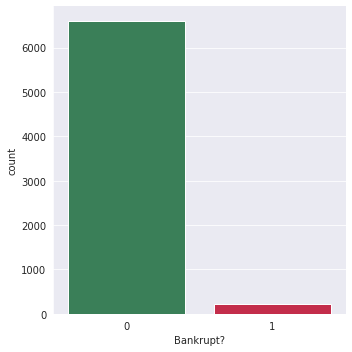

In [6]:
sns.set_style("darkgrid")
ax = sns.catplot(x='Bankrupt?', data=data, kind='count', palette=['seagreen', 'crimson'])
ax.savefig('Data_on_Bankrupt_or_Not_Bankrupt_Companies.png')
plt.show()

Within the dataset, there are few rows that indicate a company is bankrup. 

## Balance out Bankrupt?

In [7]:
# seperate out bankrupt feature
bankrupt = data['Bankrupt?'].copy()
data = data.drop(columns='Bankrupt?')
data.shape

(6819, 95)

In [8]:
# Combine over- and undersampling with SMOTE and cleaning using Tomek links
smote_tomek = SMOTETomek(random_state=0)
X_st, y_st = smote_tomek.fit_resample(data, bankrupt)

# New Bankrupt? counts
y_st.value_counts()

1    6562
0    6562
Name: Bankrupt?, dtype: int64

In [9]:
display(X_st.shape, y_st.shape)

(13124, 95)

(13124,)

## Split Data

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_st, y_st, test_size=0.2, random_state=100)

print(f'''X_train shape {X_train.shape}
y_train shape {y_train.shape}
X_test shape {X_test.shape}
y_test shape {y_test.shape}''')

X_train shape (10499, 95)
y_train shape (10499,)
X_test shape (2625, 95)
y_test shape (2625,)


In [11]:
y_train.value_counts()

0    5281
1    5218
Name: Bankrupt?, dtype: int64

## Features
Train

In [12]:
# Determine columns that have binary values to find cateogrical features
[col for col in X_train if np.isin(X_train[col].unique(), [0, 1]).all() ]

['Liability-AssetsFlag', 'NetIncomeFlag']

In [13]:
X_train['Liability-AssetsFlag'].value_counts()

0    10493
1        6
Name: Liability-AssetsFlag, dtype: int64

In [14]:
X_train['NetIncomeFlag'].value_counts()

1    10499
Name: NetIncomeFlag, dtype: int64

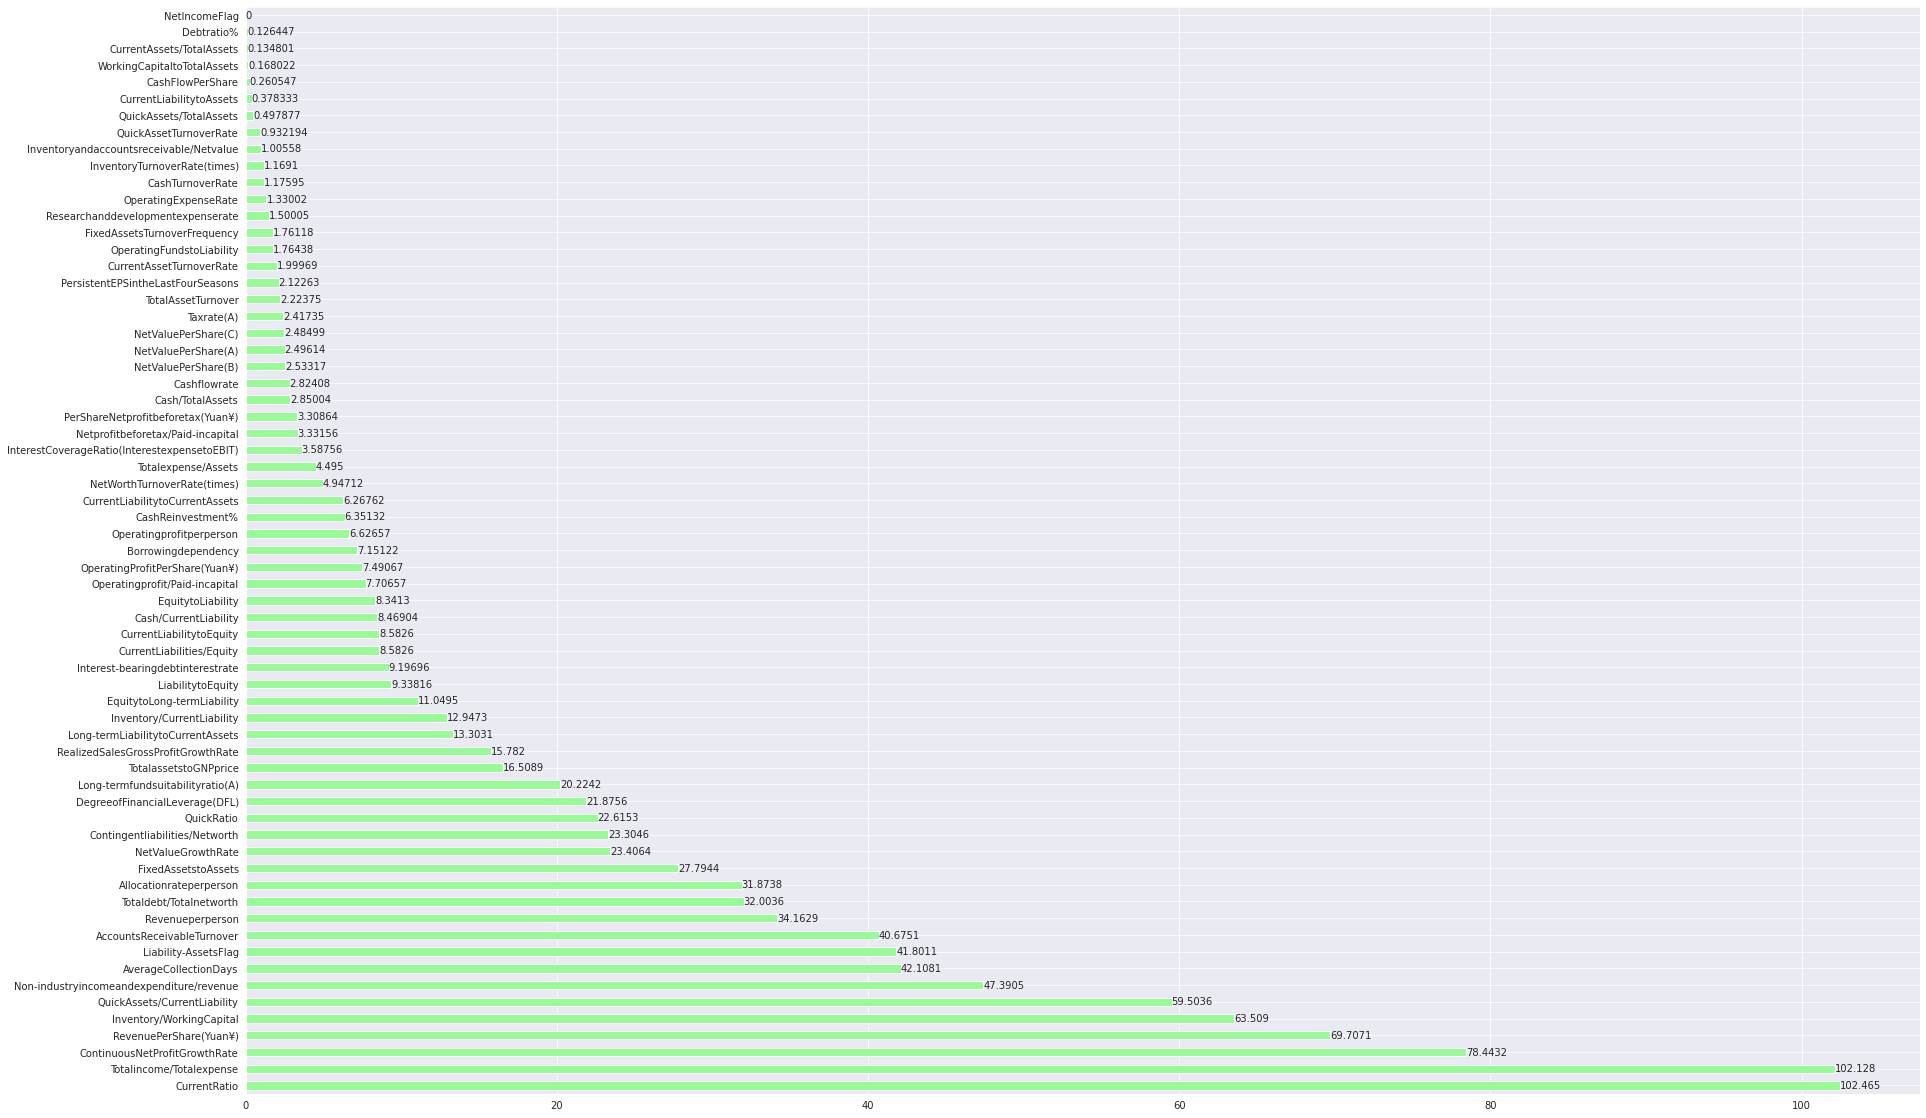

In [15]:
# For Colab
# !pip install --upgrade matplotlib
# Determine skewness of features
skew = X_train.skew()
skew_pos = skew[skew >=0].sort_values(ascending=False)
skew_neg = skew[skew <0].sort_values(ascending=True)

sns.set_style("darkgrid")

# Create barplot of positvely skewed features
plt.figure(figsize=(30,20))
ax = skew_pos.plot.barh(color='palegreen')
ax.bar_label(ax.containers[0])
plt.savefig('positively_skewed_data.png')

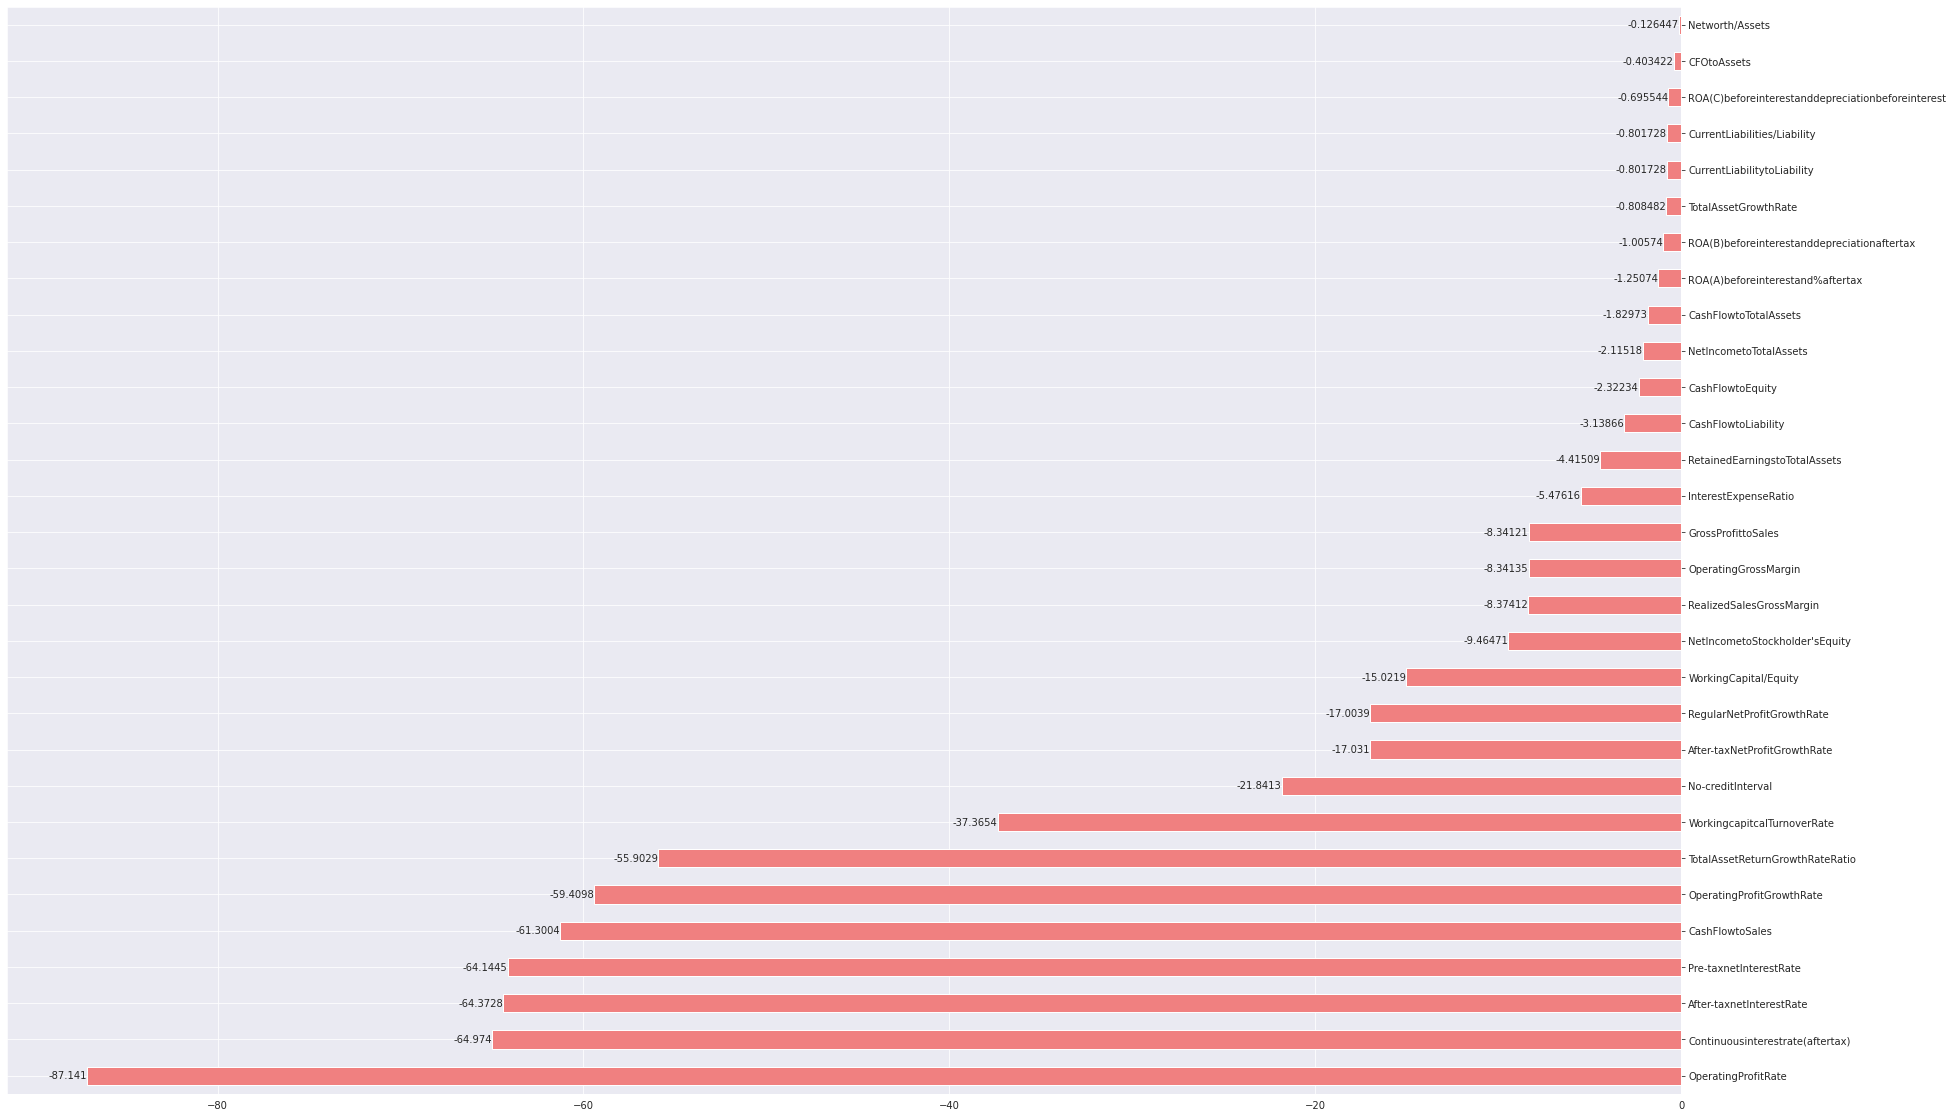

In [16]:
sns.set_style("darkgrid")

# Create barplot of negatively skewed features
plt.figure(figsize=(30,20))
ax = skew_neg.plot.barh(color='lightcoral')
ax.bar_label(ax.containers[0])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.savefig('negatively_skewed_data.png')


In [17]:
top_skew_pos = skew_pos.head()
bottom_skew_neg = skew_neg.head()

In [18]:
# Function to create stripplot and violin plot
def strip_violin (data_frame, x_axis, y_feat, skew,axis):
  sns.stripplot(data=data_frame, x=x_axis, y=y_feat, palette=['seagreen', 'crimson'],ax=axis)
  sns.violinplot(x=x_axis, y=y_feat, data=data_frame, inner=None, color=".8", ax=axis)
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  axis.text(0.25, 1.10, f"Skew = {round(skew,2)}", transform=axis.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
  return axis

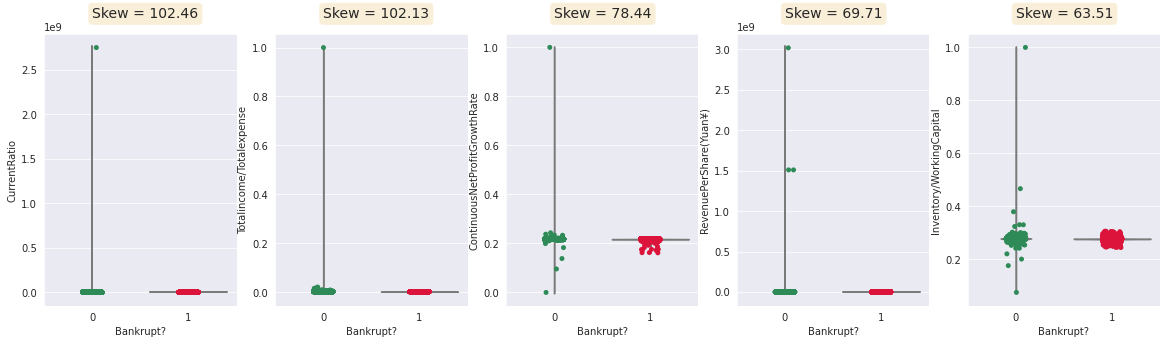

In [19]:
# Create figures to show spread of top positvely skewed features
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(20,5))

strip_violin(X_train, y_train, top_skew_pos.index[0], top_skew_pos[0], ax0)
strip_violin(X_train, y_train, top_skew_pos.index[1], top_skew_pos[1], ax1)
strip_violin(X_train, y_train, top_skew_pos.index[2], top_skew_pos[2], ax2)
strip_violin(X_train, y_train, top_skew_pos.index[3], top_skew_pos[3], ax3)
strip_violin(X_train, y_train, top_skew_pos.index[4], top_skew_pos[4], ax4)

plt.savefig('heavily_positively_skewed_violin_strip.png')
plt.show()

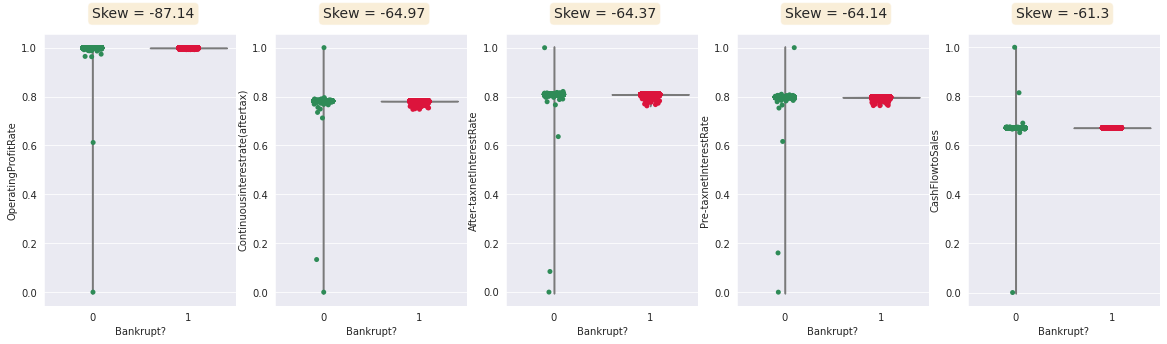

In [20]:
# Create figures to show spread of top negatively skewed features
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(20,5))

strip_violin(X_train, y_train, bottom_skew_neg.index[0], bottom_skew_neg[0], ax0)
strip_violin(X_train, y_train, bottom_skew_neg.index[1], bottom_skew_neg[1], ax1)
strip_violin(X_train, y_train, bottom_skew_neg.index[2], bottom_skew_neg[2], ax2)
strip_violin(X_train, y_train, bottom_skew_neg.index[3], bottom_skew_neg[3], ax3)
strip_violin(X_train, y_train, bottom_skew_neg.index[4], bottom_skew_neg[4], ax4)

plt.savefig('negatively_skewed_data_violin_strip.png')
plt.show()

## Data Types

In [21]:
# function to record types of features
def cat_num (data_frame):
  categorical_features = data_frame.select_dtypes(include = ["object", 'category']).columns
  numerical_features = data_frame.select_dtypes(include = ["float64"]).columns
  int_features = data_frame.select_dtypes(include = ['int64']).columns
  return categorical_features, numerical_features, int_features

### Train

In [22]:
features = cat_num(X_train)
print(f'''There are {len(features[0])} categorical features. {features[0]}
There are {len(features[1])} numerical features. {features[1]}
There are {len(features[2])} integer features. {features[2]}''')

There are 0 categorical features. Index([], dtype='object')
There are 93 numerical features. Index(['ROA(C)beforeinterestanddepreciationbeforeinterest',
       'ROA(A)beforeinterestand%aftertax',
       'ROA(B)beforeinterestanddepreciationaftertax', 'OperatingGrossMargin',
       'RealizedSalesGrossMargin', 'OperatingProfitRate',
       'Pre-taxnetInterestRate', 'After-taxnetInterestRate',
       'Non-industryincomeandexpenditure/revenue',
       'Continuousinterestrate(aftertax)', 'OperatingExpenseRate',
       'Researchanddevelopmentexpenserate', 'Cashflowrate',
       'Interest-bearingdebtinterestrate', 'Taxrate(A)', 'NetValuePerShare(B)',
       'NetValuePerShare(A)', 'NetValuePerShare(C)',
       'PersistentEPSintheLastFourSeasons', 'CashFlowPerShare',
       'RevenuePerShare(Yuan¥)', 'OperatingProfitPerShare(Yuan¥)',
       'PerShareNetprofitbeforetax(Yuan¥)',
       'RealizedSalesGrossProfitGrowthRate', 'OperatingProfitGrowthRate',
       'After-taxNetProfitGrowthRate', 'Regular

In [23]:
X_train[features[2]] = X_train[features[2]].astype('category')

features = cat_num(X_train)
cat_features = list(features[0])
num_features = list(features[1])
int_features = list(features[2])
print(f'''There are {len(features[0])} categorical features: {cat_features}
There are {len(features[1])} numerical features.
There are {len(features[2])} integer features: {int_features}.''')

There are 2 categorical features: ['Liability-AssetsFlag', 'NetIncomeFlag']
There are 93 numerical features.
There are 0 integer features: [].


### Test

In [24]:
features = cat_num(X_test)
print(f'''There are {len(features[0])} categorical features. {features[0]}
There are {len(features[1])} numerical features. {features[1]}
There are {len(features[2])} integer features. {features[2]}''')

There are 0 categorical features. Index([], dtype='object')
There are 93 numerical features. Index(['ROA(C)beforeinterestanddepreciationbeforeinterest',
       'ROA(A)beforeinterestand%aftertax',
       'ROA(B)beforeinterestanddepreciationaftertax', 'OperatingGrossMargin',
       'RealizedSalesGrossMargin', 'OperatingProfitRate',
       'Pre-taxnetInterestRate', 'After-taxnetInterestRate',
       'Non-industryincomeandexpenditure/revenue',
       'Continuousinterestrate(aftertax)', 'OperatingExpenseRate',
       'Researchanddevelopmentexpenserate', 'Cashflowrate',
       'Interest-bearingdebtinterestrate', 'Taxrate(A)', 'NetValuePerShare(B)',
       'NetValuePerShare(A)', 'NetValuePerShare(C)',
       'PersistentEPSintheLastFourSeasons', 'CashFlowPerShare',
       'RevenuePerShare(Yuan¥)', 'OperatingProfitPerShare(Yuan¥)',
       'PerShareNetprofitbeforetax(Yuan¥)',
       'RealizedSalesGrossProfitGrowthRate', 'OperatingProfitGrowthRate',
       'After-taxNetProfitGrowthRate', 'Regular

In [25]:
X_test[features[2]] = X_test[features[2]].astype('category')
features = cat_num(X_test)
cat_features = list(features[0])
num_features = list(features[1])
int_features = list(features[2])
print(f'''There are {len(features[0])} categorical features: {cat_features}
There are {len(features[1])} numerical features.
There are {len(features[2])} integer features: {int_features}.''')

There are 2 categorical features: ['Liability-AssetsFlag', 'NetIncomeFlag']
There are 93 numerical features.
There are 0 integer features: [].


## Train Correlations

In [26]:
# masked correlation heatmap
def mask_corr_graph (data_frame, columnsof_interest, fig_size=(7,5), show_corr=True, fig_name='feature_corr'):
  sns.set_theme(color_codes=True)

  features_corr = data_frame[columnsof_interest].corr()

  mask = np.zeros_like(features_corr)
  mask[np.triu_indices_from(mask)] = True

  with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=fig_size)
    ax = sns.heatmap(features_corr, annot=show_corr, linewidths=0.5, cmap="RdYlGn", mask=mask)

  ax.figure.savefig(f"{fig_name}.png")
    
  return ax

In [27]:
train = pd.concat([X_train, y_train], axis=1)
train.shape

(10499, 96)

<AxesSubplot:>

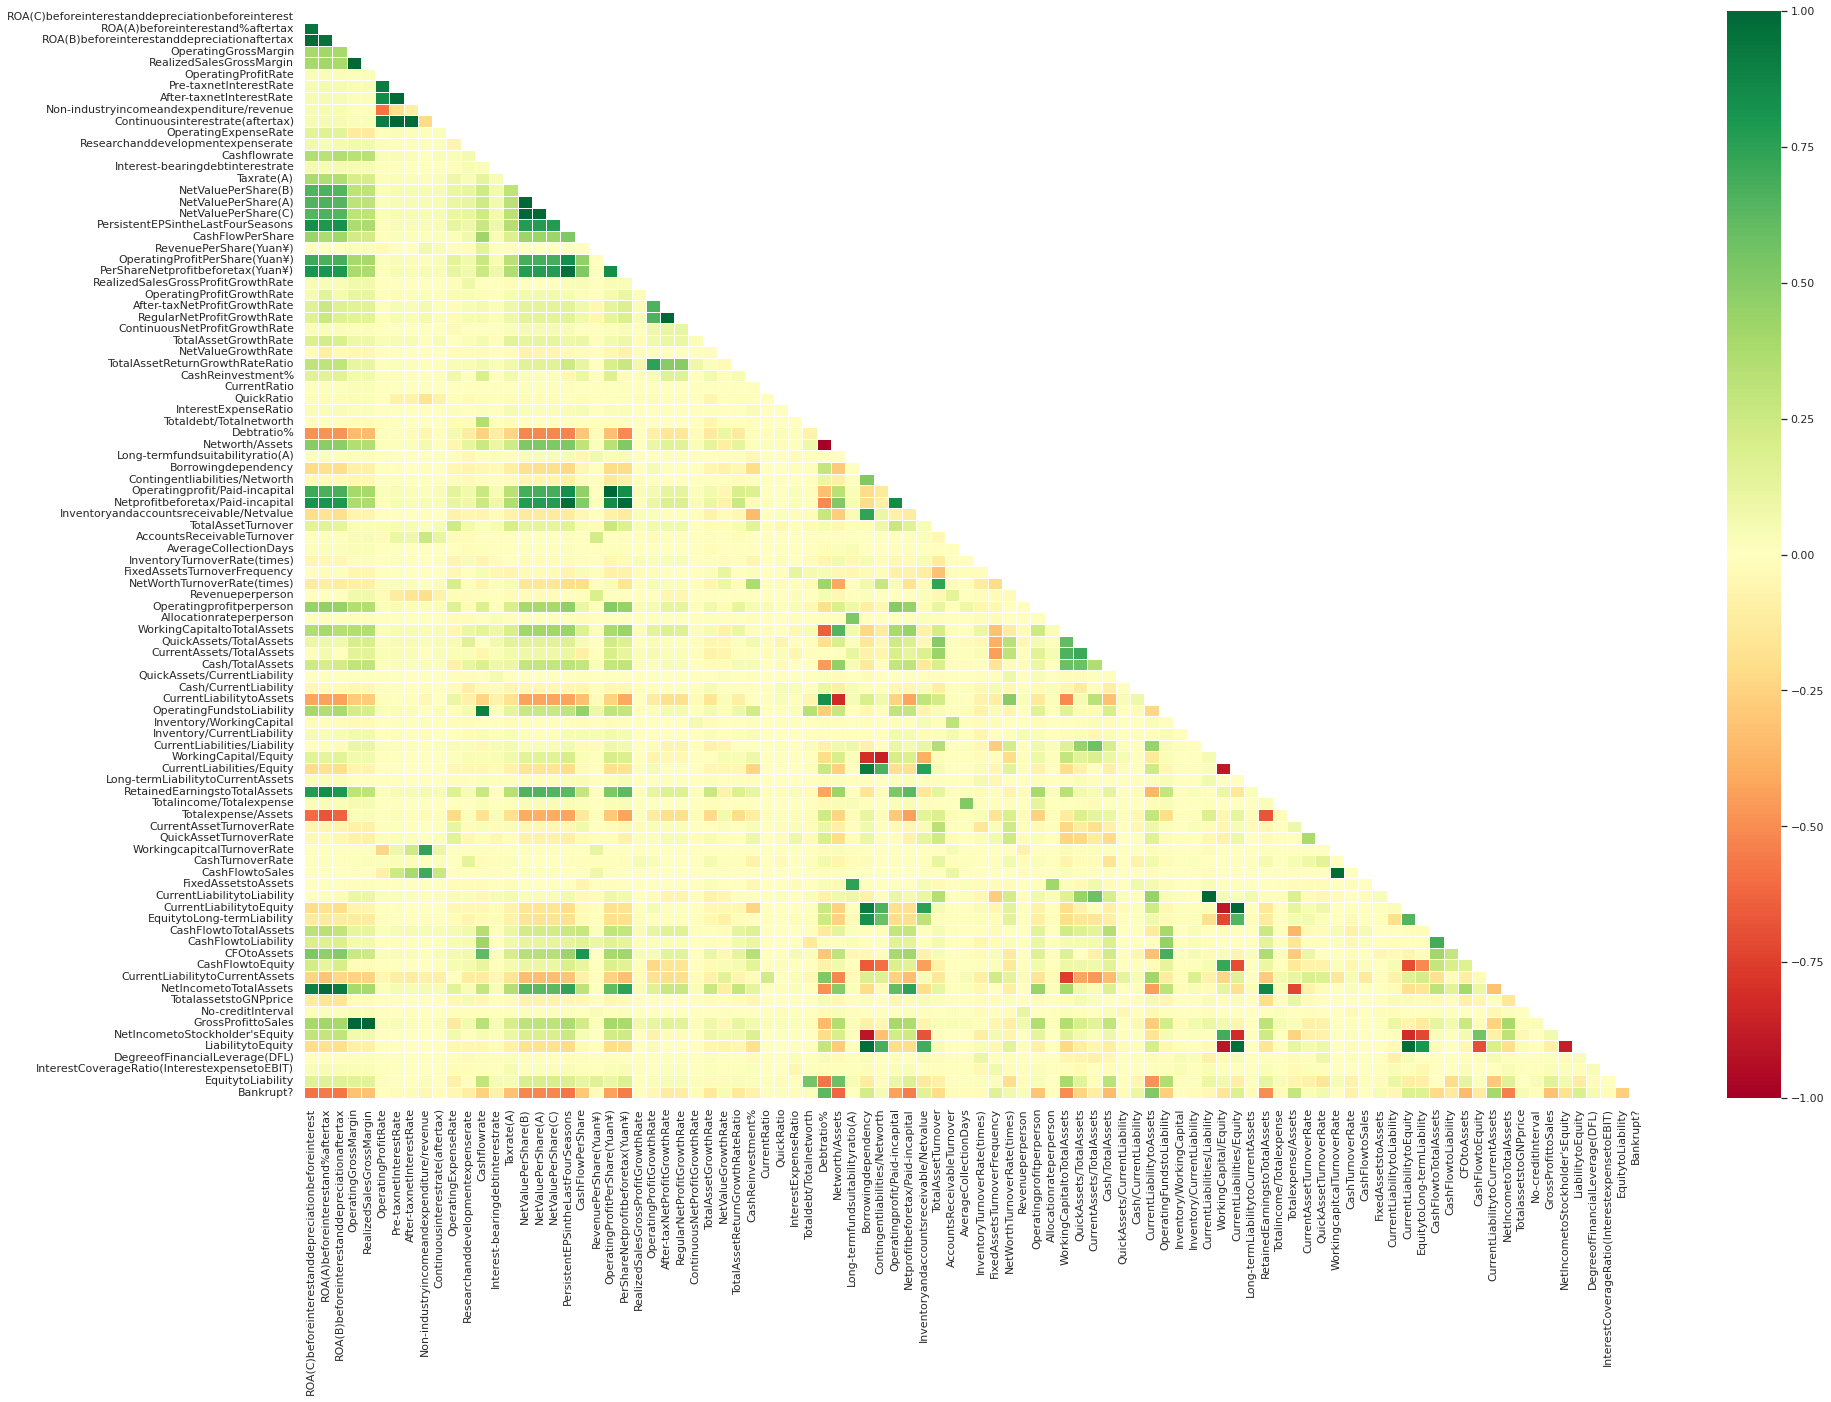

In [28]:
sns.set_style("darkgrid")
mask_corr_graph(train, train.columns, fig_size=(30,20), show_corr=False)

After performing the oversampling/undersampling with SMOTE and clean up with Tomek links, there are some features with stronger correlations to weather a company is bankrupt or not bankrupt. Some positevely correlated features are 
*   Debt ratio %, 
*   Current Liability to Assets
*   Current Liabilty to Current Assets

Negatively correlated features include:
*   Networth/Assets
*   ROA(C) before interest and depreciation before interest
*   ROA(B) before interest and depreciation after tax







In [29]:
train_corr = train.corr()['Bankrupt?'].drop(labels=['Bankrupt?'])
top10_bottom10_corr = train_corr[(train_corr >= train_corr.quantile(q=0.90)) | 
                            (train_corr <= train_corr.quantile(q=0.10))].sort_values(ascending=False)
top10_bottom10_corr

Debtratio%                                           0.621892
CurrentLiabilitytoAssets                             0.515075
CurrentLiabilitytoCurrentAssets                      0.393218
Totalexpense/Assets                                  0.278046
Borrowingdependency                                  0.213518
LiabilitytoEquity                                    0.189533
CurrentLiabilitytoEquity                             0.176496
CurrentLiabilities/Equity                            0.176496
EquitytoLong-termLiability                           0.165298
FixedAssetsTurnoverFrequency                         0.157484
NetValuePerShare(A)                                 -0.518460
NetValuePerShare(B)                                 -0.518922
NetIncometoTotalAssets                              -0.546539
PerShareNetprofitbeforetax(Yuan¥)                   -0.549500
Netprofitbeforetax/Paid-incapital                   -0.553715
ROA(A)beforeinterestand%aftertax                    -0.561713
Persiste

<AxesSubplot:xlabel='Bankrupt?', ylabel='Networth/Assets'>

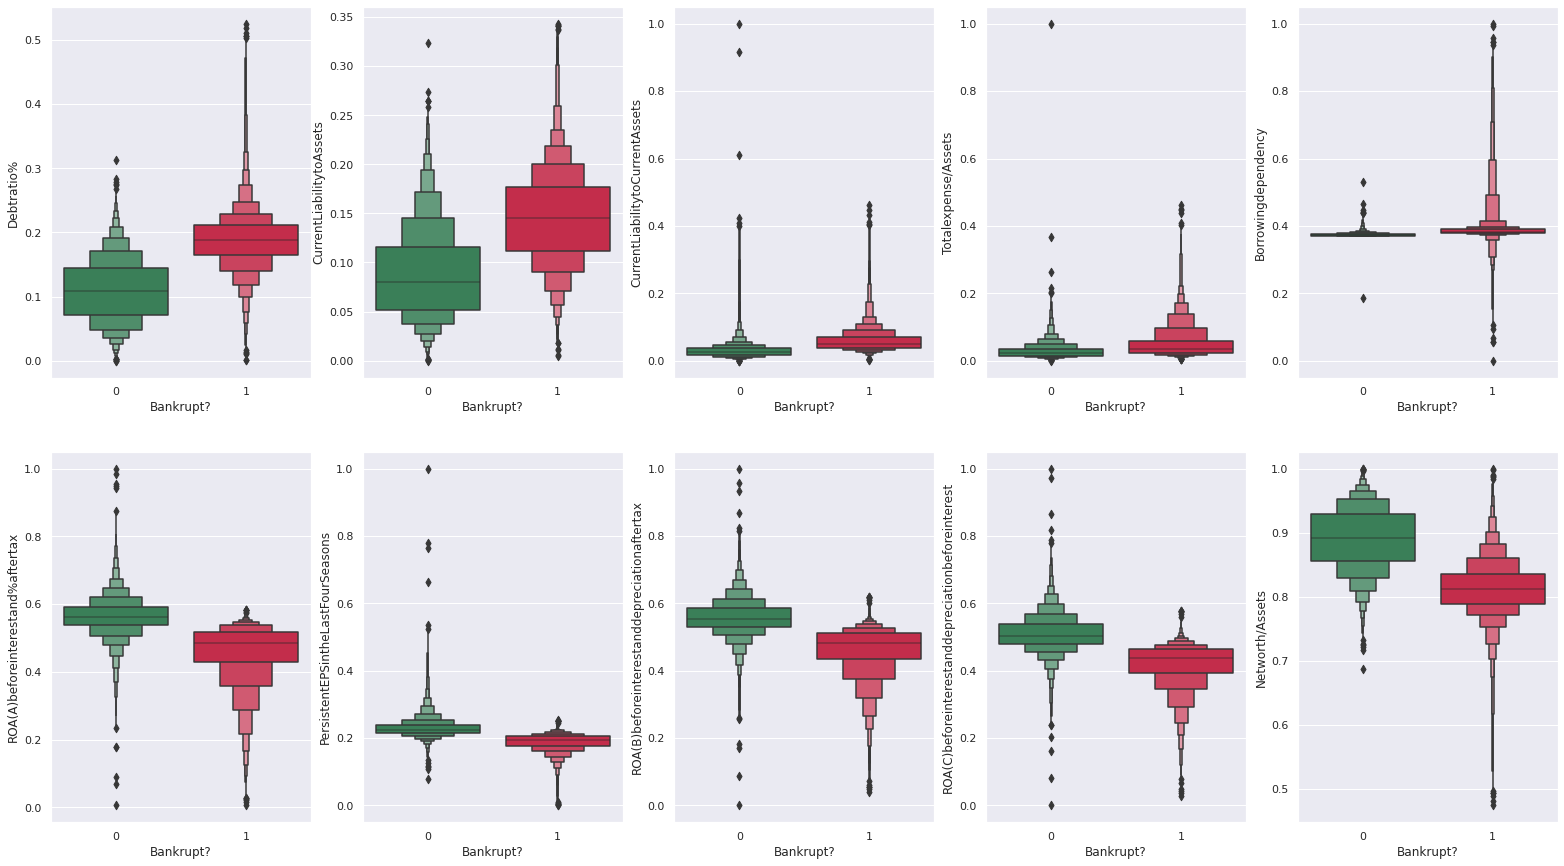

In [30]:
sns.set_style("darkgrid")

f, axes = plt.subplots(2,5, figsize=(27,15))
sns.boxenplot(x='Bankrupt?', y=top10_bottom10_corr.index[0], data=train, palette=['seagreen', 'crimson'], ax=axes[0,0])
sns.boxenplot(x='Bankrupt?', y=top10_bottom10_corr.index[1], data=train, palette=['seagreen', 'crimson'], ax=axes[0,1])
sns.boxenplot(x='Bankrupt?', y=top10_bottom10_corr.index[2], data=train, palette=['seagreen', 'crimson'], ax=axes[0,2])
sns.boxenplot(x='Bankrupt?', y=top10_bottom10_corr.index[3], data=train, palette=['seagreen', 'crimson'], ax=axes[0,3])
sns.boxenplot(x='Bankrupt?', y=top10_bottom10_corr.index[4], data=train, palette=['seagreen', 'crimson'], ax=axes[0,4])

sns.boxenplot(x='Bankrupt?', y=top10_bottom10_corr.index[15], data=train, palette=['seagreen', 'crimson'], ax=axes[1,0])
sns.boxenplot(x='Bankrupt?', y=top10_bottom10_corr.index[16], data=train, palette=['seagreen', 'crimson'], ax=axes[1,1])
sns.boxenplot(x='Bankrupt?', y=top10_bottom10_corr.index[17], data=train, palette=['seagreen', 'crimson'], ax=axes[1,2])
sns.boxenplot(x='Bankrupt?', y=top10_bottom10_corr.index[18], data=train, palette=['seagreen', 'crimson'], ax=axes[1,3])
sns.boxenplot(x='Bankrupt?', y=top10_bottom10_corr.index[19], data=train, palette=['seagreen', 'crimson'], ax=axes[1,4])


## Make Bankrupt? A Category

In [31]:
y_train = y_train.astype('category')
y_train

11534    1
9952     1
7523     1
332      0
12339    1
        ..
79       0
12119    1
8039     1
6936     1
5640     0
Name: Bankrupt?, Length: 10499, dtype: category
Categories (2, int64): [0, 1]

In [32]:
y_test = y_test.astype('category')
y_test

4967     0
689      0
11490    1
7493     1
11805    1
        ..
11569    1
7095     1
10470    1
3111     0
11949    1
Name: Bankrupt?, Length: 2625, dtype: category
Categories (2, int64): [0, 1]

## Pipeline: Preprocesseor

In [33]:
preprocessor = ColumnTransformer(transformers=[('scaler', StandardScaler(), num_features)])

# Models

### Model functions

In [34]:
def run_model (model, model_name):
  pipe = Pipeline(steps= [('preprocessor', preprocessor), (model_name, model)])
  start = time()
  fitted_model = pipe.fit(X_train, y_train)
  end = time()
  runtime = round((end - start),4)
  print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")
  return fitted_model, runtime

def prediction (fitted_model, x_feat):
  pred = fitted_model.predict(x_feat)
  return pred

def probability (fitted_model, x_feat):
  prob = fitted_model.predict_proba(x_feat)[:,1]
  return prob

def evaluating_model (y_true, y_pred, model_name, train_test):
  df=pd.DataFrame({ 'model_name': [model_name, model_name, model_name,
                                   model_name, model_name],
                   'type': [train_test, train_test, train_test,
                            train_test, train_test],
                   'metric_name': ["accuracy","f1",'recall',
                                   'precision', 'roc_auc'],
                   'metric' : [round(accuracy_score(y_true, y_pred),4),
                               round(f1_score(y_true, y_pred),4),
                               round(recall_score(y_true, y_pred), 4),
                               round(precision_score(y_true, y_pred), 4),
                               round(roc_auc_score(y_true, y_pred),4)]})
  display(df)
  return df

def prob_eval (y_true, y_prob, model_name, train_test):
  df=pd.DataFrame({ 'model_name': [model_name, model_name],
                   'type': [train_test, train_test],
                   'metric_name': ['bsl', 'log_loss'],
                   'metric' : [round(brier_score_loss(y_true, y_prob), 4),
                               round(log_loss(y_true, y_prob), 4)]})
  display(df)
  return df


def eval_classification (y_pred, y_true, x_data, model_name, train_test):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
  print(f'''
  {model_name} for {train_test} Data
  FPR {fpr}
  TPR {tpr}
  ''')

  f, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax0, 
                                   name=f'{model_name} {train_test} ROC_Curve')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax1, 
                                          name=f'{model_name} {train_test} Precision/Recall')
  plt.savefig(f'{model_name}_{train_test}_roc_prec_rec_curves.png')
  plt.show()
  return

## Logistic Regression

In [35]:
lr_model, lr_runtime = run_model(LogisticRegression(max_iter=400), 'logistic_regression')
train_pred_lr = prediction(lr_model, X_train)
train_prob_lr = probability(lr_model, X_train)

test_pred_lr = prediction(lr_model, X_test)
test_prob_lr = probability(lr_model, X_test)

logistic_regression took 1.7502 seconds or 0.0292 minutes to run.


### LG Evaluation

,model_name,type,metric_name,metric
0,LG,Train,accuracy,0.9097
1,LG,Train,f1,0.9101
2,LG,Train,recall,0.9191
3,LG,Train,precision,0.9012
4,LG,Train,roc_auc,0.9098


,model_name,type,metric_name,metric
0,LG,Train,bsl,0.0655
1,LG,Train,log_loss,0.2285



  LG for Train Data
  FPR [0.         0.09960235 1.        ]
  TPR [0.        0.9191261 1.       ]
  


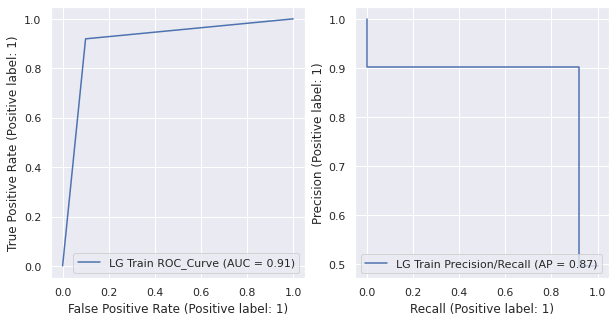

---------------------


,model_name,type,metric_name,metric
0,LG,Test,accuracy,0.9029
1,LG,Test,f1,0.9063
2,LG,Test,recall,0.9174
3,LG,Test,precision,0.8954
4,LG,Test,roc_auc,0.9025


,model_name,type,metric_name,metric
0,LG,Test,bsl,0.0701
1,LG,Test,log_loss,0.2787



  LG for Test Data
  FPR [0.         0.11241218 1.        ]
  TPR [0.         0.91741071 1.        ]
  


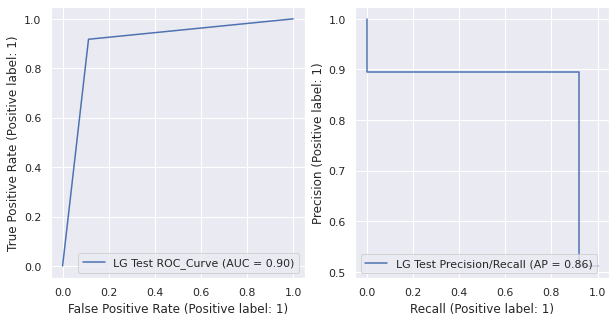

In [36]:
lg_train = evaluating_model(y_train, train_pred_lr, 'LG', 'Train')
lg_train_prob = prob_eval(y_train, train_prob_lr, 'LG', 'Train')
eval_classification(train_pred_lr, y_train, X_train, 'LG', 'Train')

print("---------------------")
lg_test = evaluating_model(y_test, test_pred_lr, 'LG', 'Test')
lg_test_prob = prob_eval(y_test, test_prob_lr, 'LG', 'Test')
eval_classification(test_pred_lr, y_test, X_test, 'LG', 'Test')

## Linear Support Vector Classification

In [37]:
LSVC_model, LSVC_runtime = run_model(LinearSVC(max_iter=140000), 'linearSVC')
train_pred_LSVC = prediction(LSVC_model, X_train)
test_pred_LSVC = prediction(LSVC_model, X_test)

#LSVC does not have probability module

linearSVC took 406.6641 seconds or 6.7777 minutes to run.


### LSVC Evaluation

,model_name,type,metric_name,metric
0,LSVC,Train,accuracy,0.9106
1,LSVC,Train,f1,0.9112
2,LSVC,Train,recall,0.9237
3,LSVC,Train,precision,0.8991
4,LSVC,Train,roc_auc,0.9106



  LSVC for Train Data
  FPR [0.         0.10244272 1.        ]
  TPR [0.         0.92372557 1.        ]
  


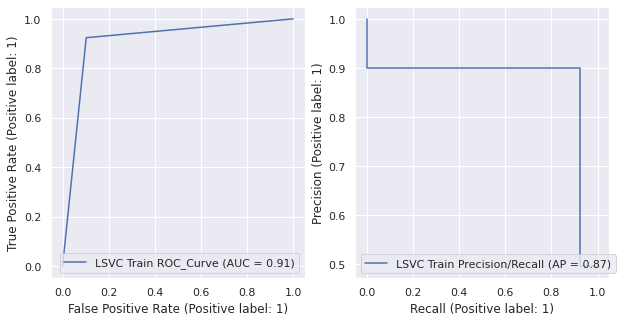

---------------------


,model_name,type,metric_name,metric
0,LSVC,Test,accuracy,0.9070
1,LSVC,Test,f1,0.9108
2,LSVC,Test,recall,0.9263
3,LSVC,Test,precision,0.8957
4,LSVC,Test,roc_auc,0.9066



  LSVC for Test Data
  FPR [0.         0.11319282 1.        ]
  TPR [0.         0.92633929 1.        ]
  


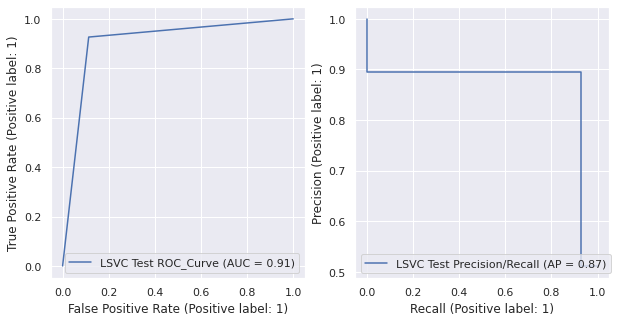

In [38]:
LSVC_train = evaluating_model(y_train, train_pred_LSVC,'LSVC', 'Train')
eval_classification(train_pred_LSVC, y_train, X_train, 'LSVC', 'Train')

print("---------------------")
LSVC_test = evaluating_model(y_test, test_pred_LSVC, 'LSVC', 'Test')
eval_classification(test_pred_LSVC, y_test, X_test, 'LSVC', 'Test')

## Gaussian Naive Bayes

In [39]:
GNB_model, GNB_runtime = run_model(GaussianNB(), 'GaussianNB')
train_pred_GNB = prediction(GNB_model, X_train)
train_prob_GNB = probability(GNB_model, X_train)

test_pred_GNB = prediction(GNB_model, X_test)
test_prob_GNB = probability(GNB_model, X_test)

GaussianNB took 0.0751 seconds or 0.0013 minutes to run.


### GNB Evaluation

,model_name,type,metric_name,metric
0,GNB,Train,accuracy,0.6822
1,GNB,Train,f1,0.7518
2,GNB,Train,recall,0.9686
3,GNB,Train,precision,0.6143
4,GNB,Train,roc_auc,0.6839


,model_name,type,metric_name,metric
0,GNB,Test,bsl,0.3055
1,GNB,Test,log_loss,6.6323



  GNB for Train Data
  FPR [0.         0.60083318 1.        ]
  TPR [0.         0.96857033 1.        ]
  


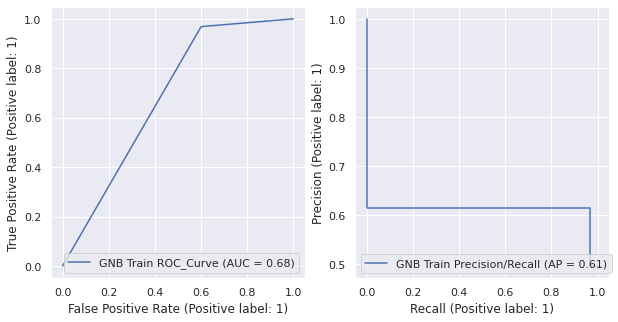

---------------------


,model_name,type,metric_name,metric
0,GNB,Test,accuracy,0.6888
1,GNB,Test,f1,0.7626
2,GNB,Test,recall,0.9762
3,GNB,Test,precision,0.6257
4,GNB,Test,roc_auc,0.6817


,model_name,type,metric_name,metric
0,GNB,Test,bsl,0.3055
1,GNB,Test,log_loss,6.6323



  GNB for Test Data
  FPR [0.        0.6128025 1.       ]
  TPR [0.         0.97619048 1.        ]
  


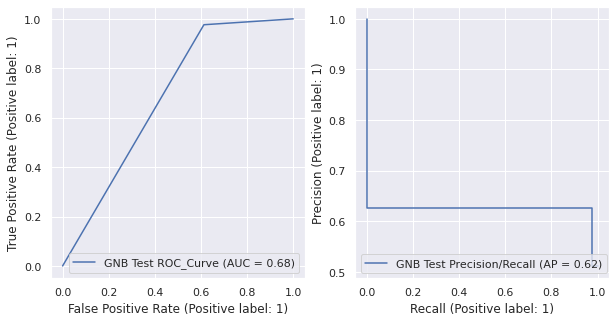

In [40]:
GNB_train = evaluating_model(y_train, train_pred_GNB, 'GNB', 'Train')
GNB_train_prob = prob_eval(y_test, test_prob_GNB, 'GNB', 'Train')
eval_classification(train_pred_GNB, y_train, X_train,'GNB', 'Train')

print("---------------------")
GNB_test = evaluating_model(y_test, test_pred_GNB,'GNB', 'Test')
GNB_test_prob = prob_eval(y_test, test_prob_GNB, 'GNB', 'Test')
eval_classification(test_pred_GNB, y_test, X_test, 'GNB', 'Test')

## Random Forest Classifier

In [43]:
RFC_model, RFC_runtime = run_model(RandomForestClassifier(), 'RandomForestClassifier')
train_pred_RFC = prediction(RFC_model, X_train)
train_prob_RFC = probability(RFC_model, X_train)

test_pred_RFC = prediction(RFC_model, X_test)
test_prob_RFC = probability(RFC_model, X_test)

RandomForestClassifier took 11.235 seconds or 0.1872 minutes to run.


### RFC Evaluation

,model_name,type,metric_name,metric
0,RFC,Train,accuracy,1.0
1,RFC,Train,f1,1.0
2,RFC,Train,recall,1.0
3,RFC,Train,precision,1.0
4,RFC,Train,roc_auc,1.0


,model_name,type,metric_name,metric
0,RFC,Train,bsl,0.003
1,RFC,Train,log_loss,0.026



  RFC for Train Data
  FPR [0. 0. 1.]
  TPR [0. 1. 1.]
  


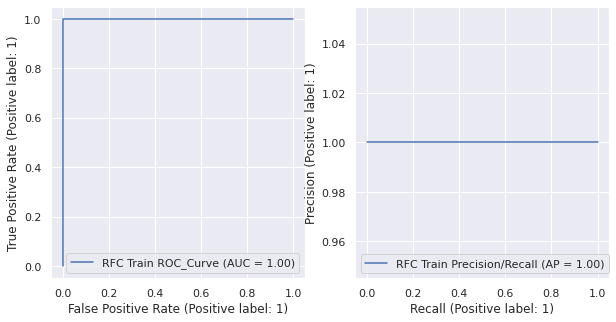

---------------------


,model_name,type,metric_name,metric
0,RFC,Test,accuracy,0.9775
1,RFC,Test,f1,0.9784
2,RFC,Test,recall,0.9948
3,RFC,Test,precision,0.9626
4,RFC,Test,roc_auc,0.9771


,model_name,type,metric_name,metric
0,RFC,Test,bsl,0.0211
1,RFC,Test,log_loss,0.0862



  RFC for Test Data
  FPR [0.         0.04059329 1.        ]
  TPR [0.         0.99479167 1.        ]
  


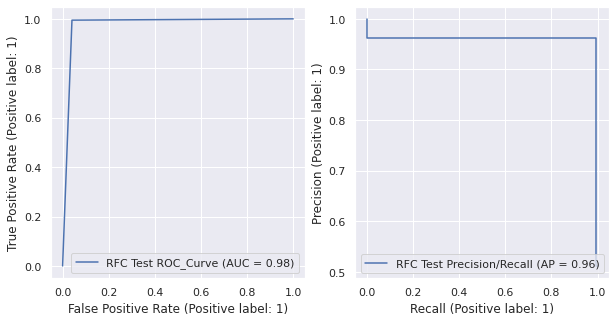

In [44]:
RFC_train = evaluating_model(y_train, train_pred_RFC, 'RFC', 'Train')
RFC_train_prob = prob_eval(y_train, train_prob_RFC, 'RFC', 'Train')
eval_classification(train_pred_RFC, y_train, X_train,'RFC', 'Train')

print("---------------------")
RFC_test = evaluating_model(y_test, test_pred_RFC,'RFC', 'Test')
RFC_test_prob = prob_eval(y_test, test_prob_RFC, 'RFC', 'Test')
eval_classification(test_pred_RFC, y_test, X_test, 'RFC', 'Test')

## Gradient Boosted Trees

In [45]:
GBT_model, GBT_runtime = run_model(GradientBoostingClassifier(), 'GradientBoostedTrees')
train_pred_GBT = prediction(GBT_model, X_train)
train_prob_GBT = probability(GBT_model, X_train)

test_pred_GBT = prediction(GBT_model, X_test)
test_prob_GBT = probability(GBT_model, X_test)

GradientBoostedTrees took 40.0254 seconds or 0.6671 minutes to run.


### GBT Evaluation

,model_name,type,metric_name,metric
0,GBT,Train,accuracy,0.9703
1,GBT,Train,f1,0.9705
2,GBT,Train,recall,0.9841
3,GBT,Train,precision,0.9573
4,GBT,Train,roc_auc,0.9704


,model_name,type,metric_name,metric
0,GBT,Train,bsl,0.0265
1,GBT,Train,log_loss,0.1083



  GBT for Train Data
  FPR [0.       0.043363 1.      ]
  TPR [0.         0.98409352 1.        ]
  


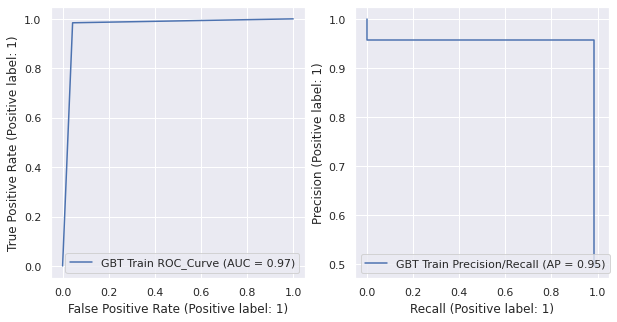

---------------------


,model_name,type,metric_name,metric
0,GBT,Test,accuracy,0.9550
1,GBT,Test,f1,0.9571
2,GBT,Test,recall,0.9784
3,GBT,Test,precision,0.9366
4,GBT,Test,roc_auc,0.9545


,model_name,type,metric_name,metric
0,GBT,Test,bsl,0.0358
1,GBT,Test,log_loss,0.1334



  GBT for Test Data
  FPR [0.         0.06947697 1.        ]
  TPR [0.         0.97842262 1.        ]
  


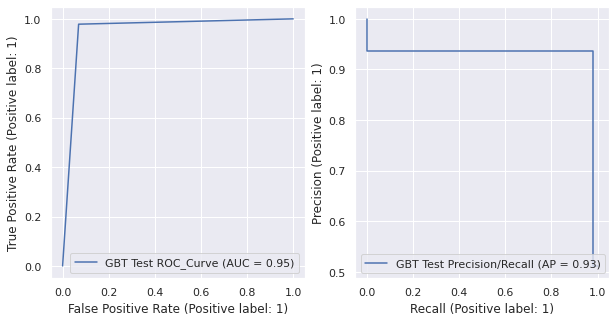

In [47]:
GBT_train = evaluating_model(y_train, train_pred_GBT, 'GBT', 'Train')
GBT_train_prob = prob_eval(y_train, train_prob_GBT, 'GBT', 'Train')
eval_classification(train_pred_GBT, y_train, X_train,'GBT', 'Train')

print("---------------------")
GBT_test = evaluating_model(y_test, test_pred_GBT,'GBT', 'Test')
GBT_test_prob = prob_eval(y_test, test_prob_GBT, 'GBT', 'Test')
eval_classification(test_pred_GBT, y_test, X_test, 'GBT', 'Test')

## Extra Tree Classifier

In [48]:
ETC_model, ETC_runtime = run_model(ExtraTreesClassifier(), 'ExtraTreeClassifier')
train_pred_ETC = prediction(ETC_model, X_train)
train_prob_ETC = probability(ETC_model, X_train)

test_pred_ETC = prediction(ETC_model, X_test)
test_prob_ETC = probability(ETC_model, X_test)

ExtraTreeClassifier took 2.3563 seconds or 0.0393 minutes to run.


### ETC Evaluation

,model_name,type,metric_name,metric
0,ETC,Train,accuracy,1.0
1,ETC,Train,f1,1.0
2,ETC,Train,recall,1.0
3,ETC,Train,precision,1.0
4,ETC,Train,roc_auc,1.0


,model_name,type,metric_name,metric
0,ETC,Train,bsl,0.0
1,ETC,Train,log_loss,0.0



  ETC for Train Data
  FPR [0. 0. 1.]
  TPR [0. 1. 1.]
  


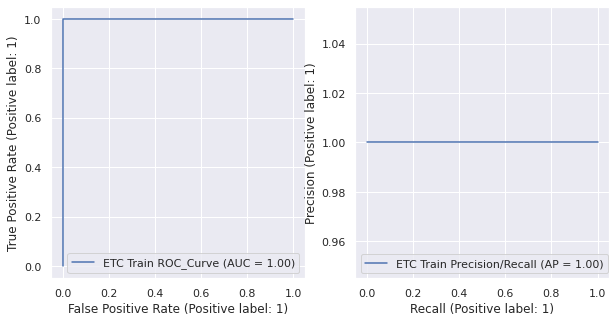

---------------------


,model_name,type,metric_name,metric
0,ETC,Test,accuracy,0.9756
1,ETC,Test,f1,0.9767
2,ETC,Test,recall,0.9963
3,ETC,Test,precision,0.9578
4,ETC,Test,roc_auc,0.9751


,model_name,type,metric_name,metric
0,ETC,Test,bsl,0.0191
1,ETC,Test,log_loss,0.0774



  ETC for Test Data
  FPR [0.         0.04605777 1.        ]
  TPR [0.         0.99627976 1.        ]
  


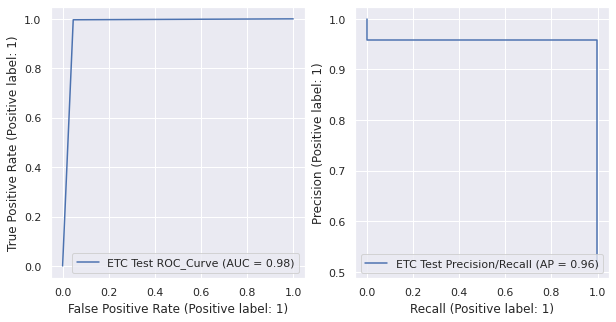

In [49]:
ETC_train = evaluating_model(y_train, train_pred_ETC, 'ETC', 'Train')
ETC_train_prob = prob_eval(y_train, train_prob_ETC, 'ETC', 'Train')
eval_classification(train_pred_ETC, y_train, X_train,'ETC', 'Train')

print("---------------------")
ETC_test = evaluating_model(y_test, test_pred_ETC,'ETC', 'Test')
ETC_test_prob = prob_eval(y_test, test_prob_ETC, 'ETC', 'Test')
eval_classification(test_pred_ETC, y_test, X_test, 'ETC', 'Test')

## Compare Models

In [50]:
model_compare = pd.concat([lg_test, lg_test_prob, lg_train, lg_train_prob, LSVC_train, LSVC_test,
                           GNB_train, GNB_train_prob, GNB_test, GNB_test_prob,
                           RFC_train, RFC_train_prob, RFC_test, RFC_test_prob,
                           GBT_train, GBT_train_prob, GBT_test, GBT_test_prob,
                           ETC_train, ETC_train_prob, ETC_test, ETC_test_prob])

In [51]:
def model_comparisons (df, metric, axis):
  grouped_df = model_compare[model_compare['metric_name'] == metric]

  sns.set_style("darkgrid")
  g = sns.barplot(data=grouped_df, hue='type', x='model_name', y='metric', palette='dark', ax=axis)
  g.set_ylabel(metric)
  g.set_title(f'{metric} of Models \nfor Company Bankruptcy')
  g.legend(loc=(0.6,1.15))

  return

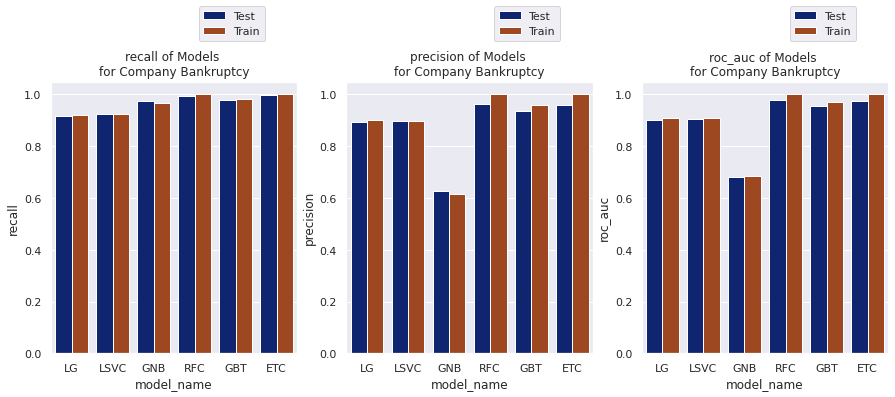

In [55]:
f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(15,5))

model_comparisons(model_compare, 'recall', ax0)
model_comparisons(model_compare, 'precision', ax1)
model_comparisons(model_compare, 'roc_auc', ax2)

f.savefig('recall_precision_roc_auc_test_train_comparison.png')

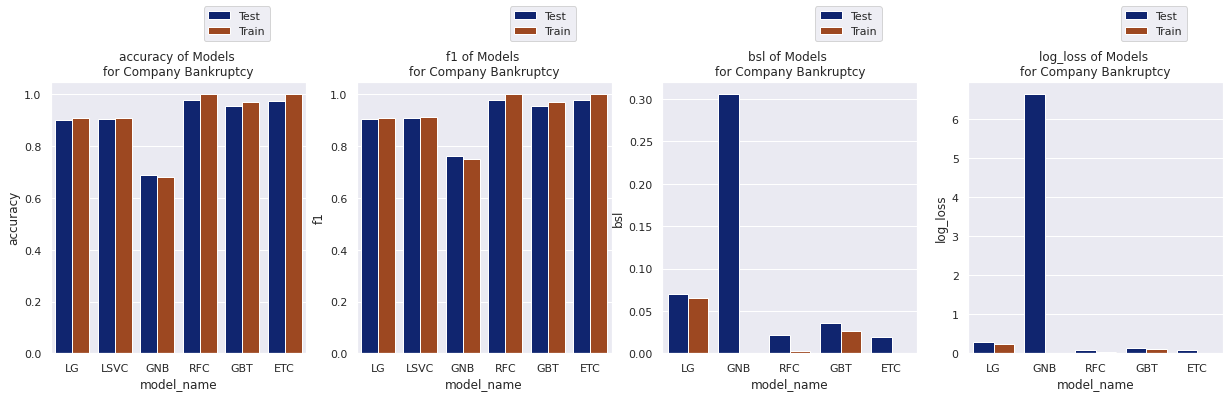

In [58]:
f, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(21,5))

model_comparisons(model_compare, 'accuracy', ax0)
model_comparisons(model_compare, 'f1', ax1)
model_comparisons(model_compare, 'bsl', ax2)
model_comparisons(model_compare, 'log_loss', ax3)

f.savefig('accuracy_f1_bsl_log_loss_traintest_comparison.png')